# Parametrized Quantum Circuits for Reinforcement Learning


Quantum computers have been shown to provide computational advantages in certain problem areas. The field of quantum reinforcement learning (QRL) aims to harness this boost by designing RL agents that rely on quantum models of computation.

In this tutorial, you will implement two reinforcement learning algorithms based on parametrized/variational quantum circuits (PQCs or VQCs), namely a policy-gradient and a deep Q-learning implementation. These algorithms were introduced by [[1] Jerbi et al.](https://arxiv.org/abs/2103.05577) and [[2] Skolik et al.](https://arxiv.org/abs/2103.15084), respectively.

You will implement a PQC with data re-uploading in TFQ, and use it as:
1. an RL policy trained with a policy-gradient method,
2. a Q-function approximator trained with deep Q-learning,

each solving [CartPole-v1](http://gym.openai.com/envs/CartPole-v1/), a benchmarking task from OpenAI Gym. Note that, as showcased in [[1]](https://arxiv.org/abs/2103.05577) and [[2]](https://arxiv.org/abs/2103.15084), these agents can also be used to solve other task-environment from OpenAI Gym, such as [FrozenLake-v0](http://gym.openai.com/envs/FrozenLake-v0/), [MountainCar-v0](http://gym.openai.com/envs/MountainCar-v0/) or [Acrobot-v1](http://gym.openai.com/envs/Acrobot-v1/).

Features of this implementation:
- you will learn how to use a `tfq.layers.ControlledPQC` to implement a PQC with data re-uploading, appearing in many applications of QML. This implementation also naturally allows using trainable scaling parameters at the input of the PQC, to increase its expressivity,
- you will learn how to implement observables with trainable weights at the output of a PQC, to allow a flexible range of output values,
- you will learn how a `tf.keras.Model` can be trained with non-trivial ML loss functions, i.e., that are not compatible with `model.compile` and `model.fit`, using a `tf.GradientTape`.


Now import TensorFlow and the module dependencies:

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

import gym, cirq, sympy
import numpy as np
from functools import reduce
from collections import deque, defaultdict
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from tqdm.notebook import trange, tqdm
tf.get_logger().setLevel('ERROR')

2021-09-23 23:11:55.542813: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-09-23 23:11:57.027034: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-09-23 23:11:57.074325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 23:11:57.074847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 68 deviceMemorySize: 9.76GiB deviceMemoryBandwidth: 707.88GiB/s
2021-09-23 23:11:57.074870: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-09-23 23:11:57.077419: I tensorflow/stream_executor/pla

In [3]:
import wandb
wandb.login()

wandb: Currently logged in as: lautaro-hickmann (use `wandb login --relogin` to force relogin)


True

In [4]:
run = wandb.init(project="CartPole-V1",
           group="QML-Analytical",         
           name="Run-1")

2021-09-23 23:11:59.105498: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## 1. Build a PQC with data re-uploading

At the core of both RL algorithms you are implementing is a PQC that takes as input the agent's state $s$ in the environment (i.e., a numpy array) and outputs a vector of expectation values. These expectation values are then post-processed, either to produce an agent's policy $\pi(a|s)$ or approximate Q-values $Q(s,a)$. In this way, the PQCs are playing an analog role to that of deep neural networks in modern deep RL algorithms.

A popular way to encode an input vector in a PQC is through the use of single-qubit rotations, where rotation angles are controlled by the components of this input vector. In order to get a [highly-expressive model](https://arxiv.org/abs/2008.08605), these single-qubit encodings are not performed only once in the PQC, but in several "[re-uploadings](https://quantum-journal.org/papers/q-2020-02-06-226/)", interlayed with variational gates. The layout of such a PQC is depicted below:

<img src="images/pqc_re-uploading.png" width="700"/>

As discussed in [[1]](https://arxiv.org/abs/2103.05577) and [[2]](https://arxiv.org/abs/2103.15084), a way to further enhance the expressivity and trainability of data re-uploading PQCs is to use trainable input-scaling parameters $\boldsymbol{\lambda}$ for each encoding gate of the PQC, and trainable observable weights $\boldsymbol{w}$ at its output.

### 1.1 Cirq circuit for ControlledPQC

The first step is to implement in Cirq the quantum circuit to be used as the PQC. For this, start by defining basic unitaries to be applied in the circuits, namely an arbitrary single-qubit rotation and an entangling layer of CZ gates:

In [5]:
def one_qubit_rotation(qubit, symbols):
    """
    Returns Cirq gates that apply a rotation of the bloch sphere about the X,
    Y and Z axis, specified by the values in `symbols`.
    """
    return [cirq.rx(symbols[0])(qubit),
            cirq.ry(symbols[1])(qubit),
            cirq.rz(symbols[2])(qubit)]

def entangling_layer(qubits):
    """
    Returns a layer of CZ entangling gates on `qubits` (arranged in a circular topology).
    """
    cz_ops = [cirq.CZ(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
    cz_ops += ([cirq.CZ(qubits[0], qubits[-1])] if len(qubits) != 2 else [])
    return cz_ops

Now, use these functions to generate the Cirq circuit:

In [6]:
def generate_circuit(qubits, n_layers):
    """Prepares a data re-uploading circuit on `qubits` with `n_layers` layers."""
    # Number of qubits
    n_qubits = len(qubits)
    
    # Sympy symbols for variational angles
    params = sympy.symbols(f'theta(0:{3*(n_layers+1)*n_qubits})')
    params = np.asarray(params).reshape((n_layers + 1, n_qubits, 3))
    
    # Sympy symbols for encoding angles
    inputs = sympy.symbols(f'x(0:{n_qubits})'+f'(0:{n_layers})')
    inputs = np.asarray(inputs).reshape((n_layers, n_qubits))
    
    # Define circuit
    circuit = cirq.Circuit()
    for l in range(n_layers):
        # Variational layer
        circuit += cirq.Circuit(one_qubit_rotation(q, params[l, i]) for i, q in enumerate(qubits))
        circuit += entangling_layer(qubits)
        # Encoding layer
        circuit += cirq.Circuit(cirq.rx(inputs[l, i])(q) for i, q in enumerate(qubits))

    # Last varitional layer
    circuit += cirq.Circuit(one_qubit_rotation(q, params[n_layers, i]) for i,q in enumerate(qubits))
    
    return circuit, list(params.flat), list(inputs.flat)

Check that this produces a circuit that is alternating between variational and encoding layers.

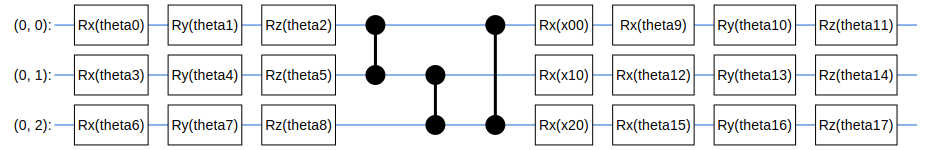

In [7]:
n_qubits, n_layers = 3, 1
qubits = cirq.GridQubit.rect(1, n_qubits)
circuit, _, _ = generate_circuit(qubits, n_layers)
SVGCircuit(circuit)

### ReUploadingPQC layer using ControlledPQC

To construct the re-uploading PQC from the figure above, you can create a custom Keras layer. This layer will manage the trainable parameters (variational angles $\boldsymbol{\theta}$ and input-scaling parameters $\boldsymbol{\lambda}$) and resolve the input values (input state $s$) into the appropriate symbols in the circuit.

In [8]:
class ReUploadingPQC(tf.keras.layers.Layer):
    """
    Performs the transformation (s_1, ..., s_d) -> (theta_1, ..., theta_N, lmbd[1][1]s_1, ..., lmbd[1][M]s_1,
        ......., lmbd[d][1]s_d, ..., lmbd[d][M]s_d) for d=input_dim, N=theta_dim and M=n_layers.
    An activation function from tf.keras.activations, specified by `activation` ('linear' by default) is
        then applied to all lmbd[i][j]s_i.
    All angles are finally permuted to follow the alphabetical order of their symbol names, as processed
        by the ControlledPQC.
    """

    def __init__(self, qubits, n_layers, observables, activation="linear", name="re-uploading_PQC"):
        super(ReUploadingPQC, self).__init__(name=name)
        self.n_layers = n_layers
        self.n_qubits = len(qubits)

        circuit, theta_symbols, input_symbols = generate_circuit(qubits, n_layers)

        theta_init = tf.random_uniform_initializer(minval=0.0, maxval=np.pi)
        self.theta = tf.Variable(
            initial_value=theta_init(shape=(1, len(theta_symbols)), dtype="float32"),
            trainable=True, name="thetas"
        )
        
        lmbd_init = tf.ones(shape=(self.n_qubits * self.n_layers,))
        self.lmbd = tf.Variable(
            initial_value=lmbd_init, dtype="float32", trainable=True, name="lambdas"
        )
        
        # Define explicit symbol order.
        symbols = [str(symb) for symb in theta_symbols + input_symbols]
        self.indices = tf.constant([sorted(symbols).index(a) for a in symbols])
        
        self.activation = activation
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
        self.computation_layer = tfq.layers.ControlledPQC(circuit, observables)        

    def call(self, inputs):
        # inputs[0] = encoding data for the state.
        batch_dim = tf.gather(tf.shape(inputs[0]), 0)
        tiled_up_circuits = tf.repeat(self.empty_circuit, repeats=batch_dim)
        tiled_up_thetas = tf.tile(self.theta, multiples=[batch_dim, 1])
        tiled_up_inputs = tf.tile(inputs[0], multiples=[1, self.n_layers])
        scaled_inputs = tf.einsum("i,ji->ji", self.lmbd, tiled_up_inputs)
        squashed_inputs = tf.keras.layers.Activation(self.activation)(scaled_inputs)

        joined_vars = tf.concat([tiled_up_thetas, squashed_inputs], axis=1)
        joined_vars = tf.gather(joined_vars, self.indices, axis=1)
        
        return self.computation_layer([tiled_up_circuits, joined_vars])



## 3. Deep Q-learning with PQC Q-function approximators

In this section, you will move to the implementation of the deep Q-learning algorithm presented in <a href="https://arxiv.org/abs/2103.15084" class="external">[2]</a>. As opposed to a policy-gradient approach, the deep Q-learning method uses a PQC to approximate the Q-function of the agent. That is, the PQC defines a function approximator:
$$ Q_\theta(s,a) = \langle O_a \rangle_{s,\theta} $$
where $\langle O_a \rangle_{s,\theta}$ are expectation values of observables $O_a$ (one per action) measured at the ouput of the PQC.

These Q-values are updated using a loss function derived from Q-learning:
$$ \mathcal{L}(\theta) = \frac{1}{|\mathcal{B}|}\sum_{s,a,r,s' \in \mathcal{B}} \left(Q_\theta(s,a) - [r +\max_{a'} Q_{\theta'}(s',a')]\right)^2$$
for a batch $\mathcal{B}$ of $1$-step interactions $(s,a,r,s')$ with the environment, sampled from the replay memory, and parameters $\theta'$ specifying the target PQC (i.e., a copy of the main PQC, whose parameters are sporadically copied from the main PQC throughout learning).

You can adopt the same observables used in <a href="https://arxiv.org/abs/2103.15084" class="external">[2]</a> for CartPole, namely a $Z_0Z_1$ Pauli product for action $0$ and a $Z_2Z_3$ Pauli product for action $1$. Both observables are re-scaled so their expectation values are in $[0,1]$ and weighted by an action-specific weight. To implement the re-scaling and weighting of the Pauli products, you can define again an extra `tf.keras.layers.Layer` that stores the action-specific weights and applies them multiplicatively on the expectation values $\left(1+\langle Z_0Z_1 \rangle_{s,\theta}\right)/2$ and $\left(1+\langle Z_2Z_3 \rangle_{s,\theta}\right)/2$.

In [9]:
class Rescaling(tf.keras.layers.Layer):
    def __init__(self, input_dim):
        super(Rescaling, self).__init__()
        self.input_dim = input_dim
        self.w = tf.Variable(
            initial_value=tf.ones(shape=(1,input_dim)), dtype="float32",
            trainable=True, name="obs-weights")

    def call(self, inputs):
        return tf.math.multiply((inputs+1)/2, tf.repeat(self.w,repeats=tf.shape(inputs)[0],axis=0))

Prepare the definition of your PQC and its observables:

In [10]:
n_qubits = 4 # Dimension of the state vectors in CartPole
n_layers = 5 # Number of layers in the PQC
n_actions = 2 # Number of actions in CartPole

qubits = cirq.GridQubit.rect(1, n_qubits)
ops = [cirq.Z(q) for q in qubits]
observables = [ops[0]*ops[1], ops[2]*ops[3]] # Z_0*Z_1 for action 0 and Z_2*Z_3 for action 1

Define a `tf.keras.Model` that, similarly to the PQC-policy model, constructs a Q-function approximator that is used to generate the main and target models of our Q-learning agent.

In [11]:
def generate_model_Qlearning(qubits, n_layers, n_actions, observables, target):
    """Generates a Keras model for a data re-uploading PQC Q-function approximator."""

    input_tensor = tf.keras.Input(shape=(len(qubits), ), dtype=tf.dtypes.float32, name='input')
    re_uploading_pqc = ReUploadingPQC(qubits, n_layers, observables, activation='tanh')([input_tensor])
    process = tf.keras.Sequential([Rescaling(len(observables))], name=target*"Target"+"Q-values")
    Q_values = process(re_uploading_pqc)
    model = tf.keras.Model(inputs=[input_tensor], outputs=Q_values)

    return model

model = generate_model_Qlearning(qubits, n_layers, n_actions, observables, False)
model_target = generate_model_Qlearning(qubits, n_layers, n_actions, observables, True)

model_target.set_weights(model.get_weights())

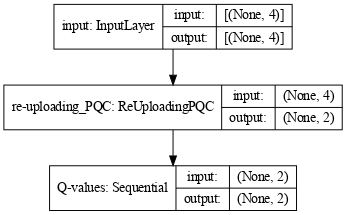

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 4)]               0         
_________________________________________________________________
re-uploading_PQC (ReUploadin (None, 2)                 92        
_________________________________________________________________
Q-values (Sequential)        (None, 2)                 2         
Total params: 94
Trainable params: 94
Non-trainable params: 0
_________________________________________________________________


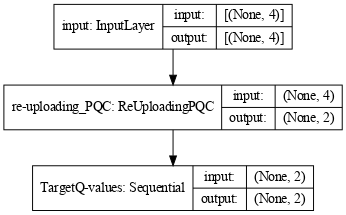

In [16]:
tf.keras.utils.plot_model(model_target, show_shapes=True, dpi=70)

In [17]:
model_target.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 4)]               0         
_________________________________________________________________
re-uploading_PQC (ReUploadin (None, 2)                 92        
_________________________________________________________________
TargetQ-values (Sequential)  (None, 2)                 2         
Total params: 94
Trainable params: 94
Non-trainable params: 0
_________________________________________________________________


You can now implement the deep Q-learning algorithm and test it on the CartPole-v1 environment. For the policy of the agent, you can use an $\varepsilon$-greedy policy:
$$ \pi(a|s) =
\begin{cases}
\delta_{a,\text{argmax}_{a'} Q_\theta(s,a')}\quad \text{w.p.}\quad 1 - \varepsilon\\
\frac{1}{\text{num_actions}}\quad \quad \quad \quad \text{w.p.}\quad \varepsilon
\end{cases} $$
where $\varepsilon$ is multiplicatively decayed at each episode of interaction.

Start by defining a function that performs an interaction step in the environment:

In [13]:
def interact_env(state, model, epsilon, n_actions, env):
    # Preprocess state
    state_array = np.array(state) 
    state = tf.convert_to_tensor([state_array])

    # Sample action
    coin = np.random.random()
    if coin > epsilon:
        q_vals = model([state])
        action = int(tf.argmax(q_vals[0]).numpy())
    else:
        action = np.random.choice(n_actions)

    # Apply sampled action in the environment, receive reward and next state
    next_state, reward, done, _ = env.step(action)
    
    interaction = {'state': state_array, 'action': action, 'next_state': next_state.copy(),
                   'reward': reward, 'done':float(done)}
    
    return interaction

and a function that updates the Q-function using a batch of interactions:

In [14]:
@tf.function
def Q_learning_update(states, actions, rewards, next_states, done, model, gamma, n_actions):
    states = tf.convert_to_tensor(states)
    actions = tf.convert_to_tensor(actions)
    rewards = tf.convert_to_tensor(rewards)
    next_states = tf.convert_to_tensor(next_states)
    done = tf.convert_to_tensor(done)

    # Compute their target q_values and the masks on sampled actions
    future_rewards = model_target([next_states])
    target_q_values = rewards + (gamma * tf.reduce_max(future_rewards, axis=1)
                                                   * (1.0 - done))
    masks = tf.one_hot(actions, n_actions)

    # Train the model on the states and target Q-values
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        q_values = model([states])
        q_values_masked = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        loss = tf.keras.losses.Huber()(target_q_values, q_values_masked)

    # Backpropagation
    grads = tape.gradient(loss, model.trainable_variables)
    for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]):
        optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])

Define the hyperparameters:

In [15]:
gamma = 0.99
n_episodes = 2000

# Define replay memory
max_memory_length = 10000 # Maximum replay length
replay_memory = deque(maxlen=max_memory_length)

epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.01  # Minimum epsilon greedy parameter
decay_epsilon = 0.99 # Decay rate of epsilon greedy parameter
batch_size = 16
steps_per_update = 10 # Train the model every x steps
steps_per_target_update = 30 # Update the target model every x steps

Prepare the optimizers:

In [16]:
optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)

# Assign the model parameters to each optimizer
w_in, w_var, w_out = 1, 0, 2

Now implement the main training loop of the agent.

Note: This agent may need to simulate several million quantum circuits and can take as much as ~40 minutes to finish training.

In [17]:

env = gym.make("CartPole-v1")
    
episode_reward_history = []
step_count = 0
t = trange(n_episodes, desc='Training', leave=True)


for episode in t:
    episode_reward = 0
    state = env.reset()
    while True:
        # Interact with env
        interaction = interact_env(state, model, epsilon, n_actions, env)
        
        # Store interaction in the replay memory
        replay_memory.append(interaction)
        
        state = interaction['next_state']
        episode_reward += interaction['reward']
        step_count += 1
        
        # Update model
        if step_count % steps_per_update == 0:
            # Sample a batch of interactions and update Q_function
            training_batch = np.random.choice(replay_memory, size=batch_size)
            Q_learning_update(np.asarray([x['state'] for x in training_batch]),
                              np.asarray([x['action'] for x in training_batch]),
                              np.asarray([x['reward'] for x in training_batch], dtype=np.float32),
                              np.asarray([x['next_state'] for x in training_batch]),
                              np.asarray([x['done'] for x in training_batch], dtype=np.float32),
                              model, gamma, n_actions)
        
        # Update target model
        if step_count % steps_per_target_update == 0:
            model_target.set_weights(model.get_weights())
        
        # Check if the episode is finished
        if interaction['done']:
            break

    # Decay epsilon
    epsilon = max(epsilon * decay_epsilon, epsilon_min)
    episode_reward_history.append(episode_reward)
    wandb.log({'episode_reward': episode_reward}, step=step_count)

    if (episode+1)%10 == 0:
        avg_rewards = np.mean(episode_reward_history[-10:])
        print("Episode {}/{}, average last 10 rewards {}".format(
            episode+1, n_episodes, avg_rewards))
        wandb.log({'episode_reward_avg_last_10': avg_rewards, 'episode':episode+1}, step=step_count)
        t.set_description("Episode {}/{}, average last 10 rewards {}".format(episode+1, n_episodes, avg_rewards))
        t.refresh() # to show immediately the update
        if avg_rewards >= 500.0:
            break

2021-09-23 18:18:04.877487: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-23 18:18:04.899888: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3400005000 Hz


Episode 10/2000, average last 10 rewards 20.7
Episode 20/2000, average last 10 rewards 21.2
Episode 30/2000, average last 10 rewards 22.2
Episode 40/2000, average last 10 rewards 13.8
Episode 50/2000, average last 10 rewards 14.1
Episode 60/2000, average last 10 rewards 14.6
Episode 70/2000, average last 10 rewards 14.1
Episode 80/2000, average last 10 rewards 15.7
Episode 90/2000, average last 10 rewards 20.3
Episode 100/2000, average last 10 rewards 22.1
Episode 110/2000, average last 10 rewards 22.1
Episode 120/2000, average last 10 rewards 20.4
Episode 130/2000, average last 10 rewards 22.3
Episode 140/2000, average last 10 rewards 25.4
Episode 150/2000, average last 10 rewards 27.0
Episode 160/2000, average last 10 rewards 24.0
Episode 170/2000, average last 10 rewards 26.8
Episode 180/2000, average last 10 rewards 21.3
Episode 190/2000, average last 10 rewards 22.8
Episode 200/2000, average last 10 rewards 23.0
Episode 210/2000, average last 10 rewards 22.1
Episode 220/2000, aver

KeyboardInterrupt: 

Plot the learning history of the agent:

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(episode_reward_history)
plt.xlabel('Epsiode')
plt.ylabel('Collected rewards')
plt.show()

Similarly to the plot above, you should see that after ~1000 episodes, the performance of the agent gets close to optimal, i.e., 500 rewards per episode. Learning takes longer for Q-learning agents since the Q-function is a "richer" function to be learned than the policy.

In [ ]:
run.finish()


In [ ]:
from PIL import Image

env = gym.make('CartPole-v1')
state = env.reset()
frames = []
for t in range(500):
    im = Image.fromarray(env.render(mode='rgb_array'))
    frames.append(im)
    q_vals = model([state])
    action = int(tf.argmax(q_vals[0]).numpy())
    state, _, done, _ = env.step(action)
    if done:
        break
env.close()
frames[1].save('./images/gym_CartPole.gif',  save_all=True, append_images=frames[2:], optimize=False, duration=40, loop=0)

Process wandb_internal:
Traceback (most recent call last):
  File "/home/lh/miniconda3/envs/QML/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/lh/miniconda3/envs/QML/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lh/miniconda3/envs/QML/lib/python3.8/site-packages/wandb/sdk/internal/internal.py", line 152, in wandb_internal
    thread.join()
  File "/home/lh/miniconda3/envs/QML/lib/python3.8/threading.py", line 1011, in join
    self._wait_for_tstate_lock()
  File "/home/lh/miniconda3/envs/QML/lib/python3.8/threading.py", line 1027, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/home/lh/miniconda3/envs/QML/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/home/lh/miniconda3/envs/QML/lib